In [1]:
import rasterio
import os,sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from skimage.measure import regionprops

%pylab inline

Populating the interactive namespace from numpy and matplotlib


(1000L, 1000L)


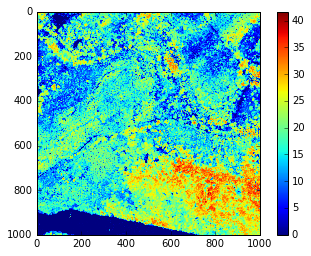

In [15]:
# read the data

dtm_name = '2016_ORNL_2_736000_3981000_DTM.tif'
dsm_name = '2016_ORNL_2_736000_3981000_DSM.tif'
dsm_dir = r'C:\Projects\RD\objectid\elev'

fi_name = os.path.join(dsm_dir, dsm_name)
with rasterio.open(fi_name) as fi:
    dsm = fi.read(1)
    pf = fi.profile
 
fi_name = os.path.join(dsm_dir, dtm_name) 
with rasterio.open(fi_name) as fi:
    dtm = fi.read(1)
    
print(dsm.shape)
ndsm = dsm -  dtm

plt.imshow(ndsm)
plt.colorbar()
plt.show()

In [16]:
# crop the middle
width = 200
r,c = ndsm.shape
r_c = int(np.floor(r/2))
c_c = int(np.floor(c/2))
ndsm_chip = ndsm[r_c - width/2 : r_c + width/2, c_c - width/2 : c_c + width/2]
ndsm_chip_sm = gaussian(ndsm_chip/ndsm_chip.max(), sigma=0.4)

(200L, 200L)


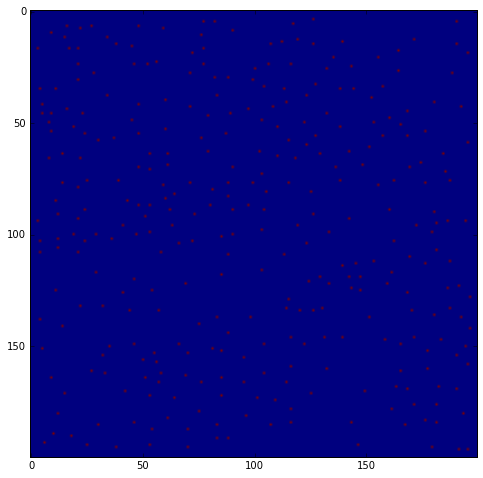

In [91]:
max_search = 3
# get local maxima as image coordinates [rows, cols]
l_max = peak_local_max(ndsm_chip_sm, min_distance = max_search)

# get local maxima as image
l_max_im = peak_local_max(ndsm_chip_sm, min_distance = max_search, indices=False)

# threshold image
ndsm_chip_bin = ndsm_chip_sm*ndsm.max() > 10

 
distance = ndi.distance_transform_edt(ndsm_chip_bin)

print(distance.shape)
# plt.imshow(distance)
# plt.show()

# get local max as image masked by the binary image
#local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=ndsm_chip_bin)
local_maxi = peak_local_max(ndsm_chip_sm, indices=False, footprint=np.ones((3, 3)), labels=ndsm_chip_bin)

# label the maximum as markers 
markers = ndi.label(local_maxi)[0]

# get the segments using watershed algorithm. (input in example is -distance, but the distance image looks like garbage in a heavily forested environment)
# labels = watershed(-distance, markers, mask=image)
labels = watershed(-ndsm_chip, markers, mask=ndsm_chip_bin)

fig = plt.figure(figsize=(8,8))
plt.imshow(l_max_im)
plt.show()

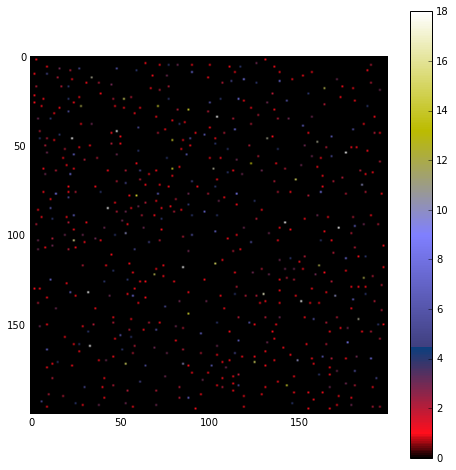

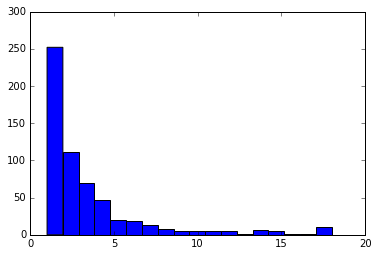

In [96]:
# create local maxima images iteratively by varying max_search
cands = []
label_list = []
boundaries_list = []
for max_search in range(2,20):
    temp = peak_local_max(ndsm_chip_sm, min_distance = max_search, indices=False, labels = ndsm_chip_bin).astype('float32')
    cands.append(temp)
    
    markers = ndi.label(temp)[0]
    
    wshed = watershed(-ndsm_chip_sm, markers, mask=ndsm_chip_bin)
    label_list.append(wshed)
    
    boundaries_list.append(mark_boundaries(ndsm_chip_sm, wshed))
    
    del temp
    del markers
    del wshed
    
# convert list into numpy array and sum
cands_arr = np.array(cands)
cands_sum = np.sum(cands_arr, axis=0)
del cands

plt.figure(figsize=(8,8))
plt.imshow(cands_sum, cmap='gist_stern')
plt.colorbar()
plt.show()

hist_im = cands_sum[cands_sum>0].flatten()
plt.hist(hist_im, bins= int(hist_im.max()))
plt.show()

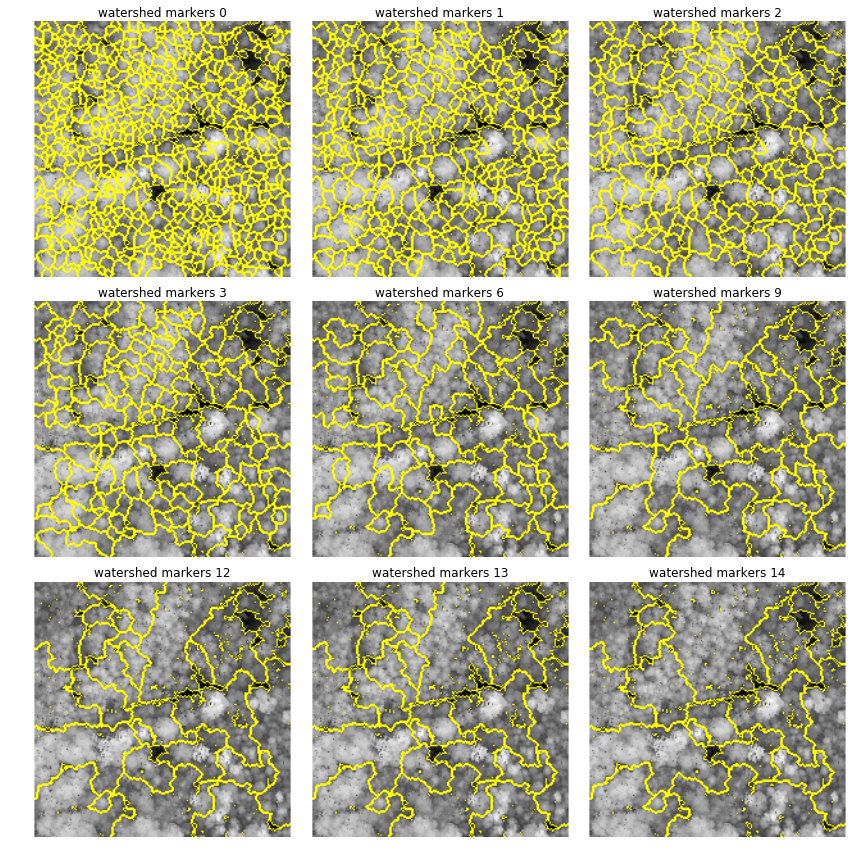

In [102]:
indexes = np.arange(0,len(boundaries_list), 1)
i= sorted(np.random.choice(indexes, 9, replace=False))

fig, ax = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

ax[0, 0].imshow(boundaries_list[i[0]])
ax[0, 0].set_title("watershed markers {}".format(i[0]))
ax[0, 1].imshow(boundaries_list[i[1]])
ax[0, 1].set_title("watershed markers {}".format(i[1]))
ax[0, 2].imshow(boundaries_list[i[2]])
ax[0, 2].set_title("watershed markers {}".format(i[2]))

ax[1, 0].imshow(boundaries_list[i[3]])
ax[1, 0].set_title("watershed markers {}".format(i[3]))
ax[1, 1].imshow(boundaries_list[i[4]])
ax[1, 1].set_title("watershed markers {}".format(i[4]))
ax[1, 2].imshow(boundaries_list[i[5]])
ax[1, 2].set_title("watershed markers {}".format(i[5]))

ax[2, 0].imshow(boundaries_list[i[6]])
ax[2, 0].set_title("watershed markers {}".format(i[6]))
ax[2, 1].imshow(boundaries_list[i[7]])
ax[2, 1].set_title("watershed markers {}".format(i[7]))
ax[2, 2].imshow(boundaries_list[i[8]])
ax[2, 2].set_title("watershed markers {}".format(i[8]))


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

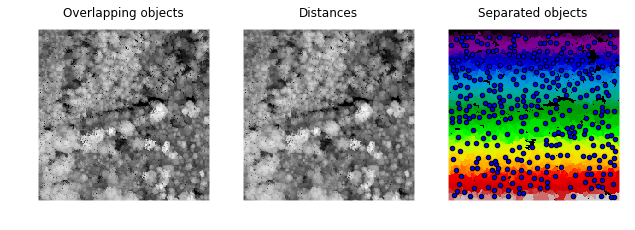

In [5]:
plot_flag = True
if plot_flag:
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()

    ax[0].imshow(ndsm_chip, cmap=plt.cm.gray, interpolation='nearest')
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(ndsm_chip_sm, cmap=plt.cm.gray, interpolation='nearest')
    ax[1].set_title('Distances')
    ax[2].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
    plt.scatter(l_max[:,1], l_max[:,0])
    ax[2].set_title('Separated objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()


# sample the dsm with the segments
label_props = regionprops(labels, intensity_image=ndsm_chip)


# create local maxima images iteratively by varying max_search
cands = []
for max_search in range(1,20):
    cands.append(peak_local_max(ndsm_chip_sm, min_distance = max_search, indices=False, labels = ndsm_chip_bin).astype('float32'))
    
# convert list into numpy array and sum
cands_arr = np.array(cands)
cands_sum = np.sum(cands_arr, axis=0)
del cands

# run watershed workflow
thresh=5
sum_max = cands_sum > thresh
markers = ndi.label(sum_max)[0]
labels = watershed(-ndsm_chip_sm, markers, mask=ndsm_chip_bin)

array([17, 12,  2, 13])

In [7]:
labels.shape

(40000L,)

In [10]:
ndsm_chip_sm.reshape(-1,1).shape

(40000L, 1L)

In [11]:
pf['transform']

Affine(1.0, 0.0, 736000.0,
       0.0, -1.0, 3982000.0)

In [12]:
shp_c = ndsm_chip_sm.shape
shp = ndsm.shape

# some pixel coordinates for the corners
ul_y = r_c - width/2
ul_x = c_c - width/2
lr_y = r_c + width/2
lr_x = c_c + width/2

chip_ul_y = pf['transform'].f + pf['transform'].e*ul_y
chip_ul_x = pf['transform'].c + pf['transform'].e*ul_x

# chip
rows = np.arange(chip_ul_y, chip_ul_y + shp_c[0]*pf['transform'].e, pf['transform'].e)
cols = np.arange(chip_ul_x, chip_ul_x + shp_c[1]*pf['transform'].c, pf['transform'].c)

# full image
# rows = np.arange(pf['transform'].f, pf['transform'].f + shp[0]*pf['transform'].e, pf['transform'].e)
# cols = np.arange(pf['transform'].c, pf['transform'].c + shp[0]*pf['transform'].a, pf['transform'].a)

gridx, gridy = np.meshgrid(cols, rows)

Felzenszwalb number of segments: 98
SLIC number of segments: 225
Quickshift number of segments: 275


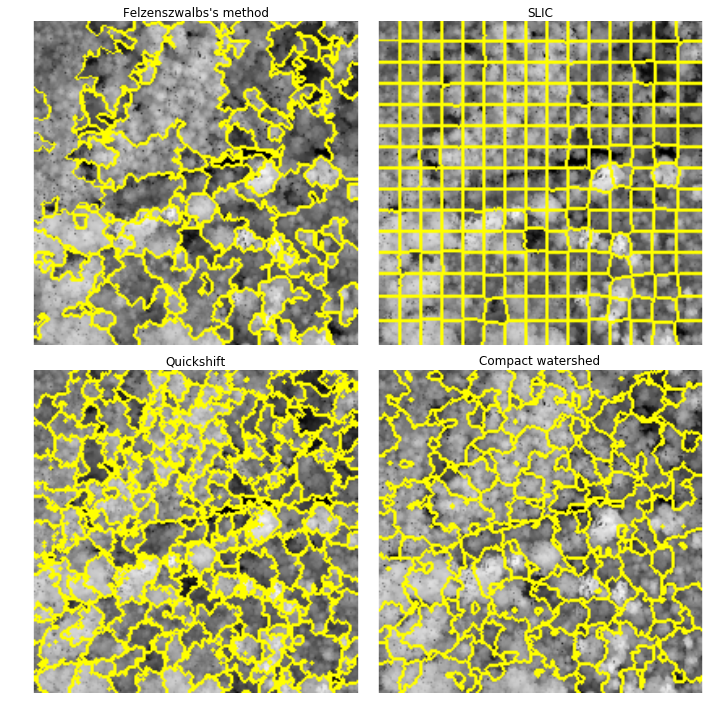

In [30]:
# from skimage.data import astronaut
# from skimage.color import rgb2gray

from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed #, chan_vese # not in v0.13.x
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = ndsm_chip_sm

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=1, sigma=.1)
segments_quick = quickshift(np.dstack((img,img,img)), kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(img)
segments_watershed = watershed(img, markers=250, compactness=0.001)
#segments_chanvese = chan_vese(img, mu=0.25, lambda1=1.0, lambda2=1.0, tol=0.001, max_iter=500, 
#          dt=0.5, init_level_set='checkerboard', extended_output=False)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

watershed number of segments: 225


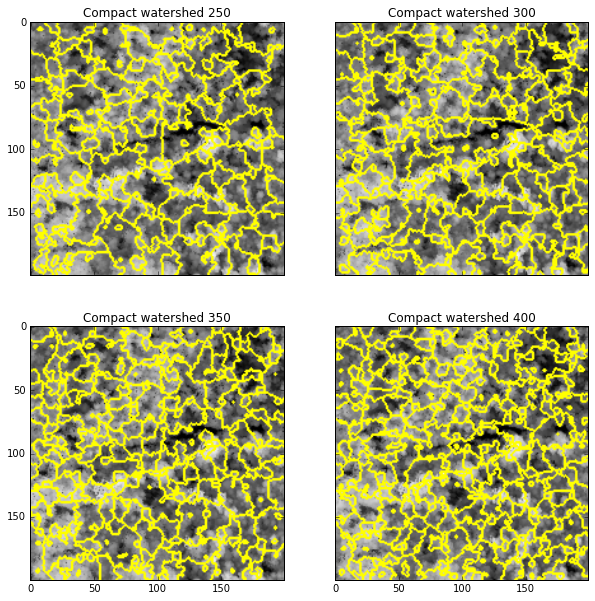

In [31]:
segments_watershed250 = watershed(img, markers=250, compactness=0.001)
segments_watershed300 = watershed(img, markers=300, compactness=0.001)
segments_watershed350 = watershed(img, markers=350, compactness=0.001)
segments_watershed400 = watershed(img, markers=400, compactness=0.001)

#segments_chanvese = chan_vese(img, mu=0.25, lambda1=1.0, lambda2=1.0, tol=0.001, max_iter=500, 
#          dt=0.5, init_level_set='checkerboard', extended_output=False)

print('watershed number of segments: {}'.format(len(np.unique(segments_watershed250))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_watershed250))
ax[0, 0].set_title("Compact watershed 250")
ax[0, 1].imshow(mark_boundaries(img, segments_watershed300))
ax[0, 1].set_title('Compact watershed 300')
ax[1, 0].imshow(mark_boundaries(img, segments_watershed350))
ax[1, 0].set_title('Compact watershed 350')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed400))
ax[1, 1].set_title('Compact watershed 400')

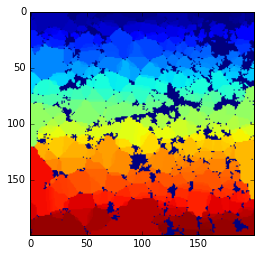

In [52]:
## try distance to background
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

bool_im = ndsm_chip > 10
distance = ndi.distance_transform_edt(bool_im)
local_maxi = peak_local_max(distance, labels=bool_im, footprint=np.ones((3, 3)), indices=False)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=bool_im)
plt.imshow(labels)

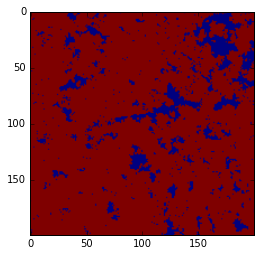

In [51]:
plt.imshow(ndsm_chip>10.0)

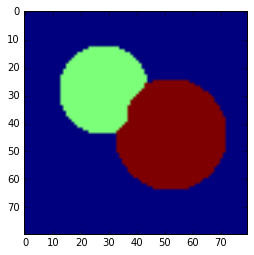

In [39]:
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)
image.shape

distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, labels=image, footprint=np.ones((3, 3)), indices=False)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)
plt.imshow(labels)

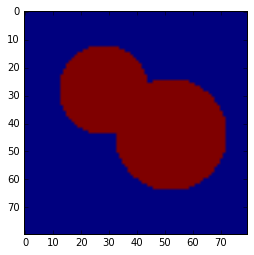

In [40]:
plt.imshow(image)

In [41]:
image

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)